In [1]:
# Basic Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For tesxt:
import re

# For times:
import time

# Set a random seed for imputation
#  Source:  https://numpy.org/doc/stable/reference/random/generated/numpy.random.seed.html
np.random.seed(42)

# Sklearn
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.metrics import r2_score, mean_squared_error

# For the recommender
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity

---
---
# Quick Recommender Test

In [2]:
lstn = pd.read_csv('../data/prepped_training.csv')

In [3]:
validation = pd.read_csv('../data/prepped_validation.csv')

In [4]:
# Need to create a sparse matrix from the dataframe
lstn_sparse = sparse.csr_matrix(lstn.drop(columns = ['price', 'log_price']))

In [5]:
lstn_similarities = cosine_similarity(lstn_sparse)

In [6]:
lstn_similarities

array([[1.        , 0.9999799 , 0.99898464, ..., 0.99995238, 0.99992754,
        0.99831269],
       [0.9999799 , 1.        , 0.9989273 , ..., 0.99995941, 0.99992367,
        0.99823207],
       [0.99898464, 0.9989273 , 1.        , ..., 0.99856622, 0.99858148,
        0.99969097],
       ...,
       [0.99995238, 0.99995941, 0.99856622, ..., 1.        , 0.99996121,
        0.99780594],
       [0.99992754, 0.99992367, 0.99858148, ..., 0.99996121, 1.        ,
        0.99772996],
       [0.99831269, 0.99823207, 0.99969097, ..., 0.99780594, 0.99772996,
        1.        ]])

In [7]:
rec = pd.DataFrame(lstn_similarities, index=lstn.index, columns=lstn.index)
rec

,0,1,2,3,4,5,6,7,8,9,...,2771,2772,2773,2774,2775,2776,2777,2778,2779,2780
0,1.000000,0.999980,0.998985,0.996476,0.998994,0.998978,0.998831,0.998772,0.998670,0.999749,...,0.999118,0.999775,0.999765,0.996368,0.999731,0.998832,0.999021,0.999952,0.999928,0.998313
1,0.999980,1.000000,0.998927,0.996427,0.998871,0.998849,0.998755,0.998693,0.998579,0.999787,...,0.999045,0.999806,0.999824,0.996361,0.999782,0.998732,0.998973,0.999959,0.999924,0.998232
2,0.998985,0.998927,1.000000,0.995735,0.999647,0.999683,0.999869,0.999868,0.999743,0.997987,...,0.999768,0.997896,0.997947,0.995831,0.997883,0.999746,0.999903,0.998566,0.998581,0.999691
3,0.996476,0.996427,0.995735,1.000000,0.995385,0.995357,0.995272,0.995198,0.995082,0.996192,...,0.995520,0.996248,0.996230,0.999933,0.996189,0.995218,0.995809,0.996465,0.996449,0.996556
4,0.998994,0.998871,0.999647,0.995385,1.000000,0.999978,0.999889,0.999835,0.999881,0.997990,...,0.999927,0.997857,0.997840,0.995218,0.997849,0.999949,0.999760,0.998581,0.998458,0.999495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2776,0.998832,0.998732,0.999746,0.995218,0.999949,0.999927,0.999944,0.999948,0.999983,0.997836,...,0.999970,0.997619,0.997623,0.995133,0.997677,1.000000,0.999874,0.998381,0.998269,0.999617
2777,0.999021,0.998973,0.999903,0.995809,0.999760,0.999737,0.999911,0.999938,0.999886,0.998114,...,0.999902,0.997937,0.997974,0.995869,0.997988,0.999874,1.000000,0.998604,0.998546,0.999758
2778,0.999952,0.999959,0.998566,0.996465,0.998581,0.998566,0.998376,0.998297,0.998194,0.999873,...,0.998731,0.999915,0.999910,0.996340,0.999880,0.998381,0.998604,1.000000,0.999961,0.997806
2779,0.999928,0.999924,0.998581,0.996449,0.998458,0.998459,0.998284,0.998239,0.998086,0.999845,...,0.998625,0.999905,0.999892,0.996350,0.999849,0.998269,0.998546,0.999961,1.000000,0.997730


# Recommender Data Entry

In [8]:
'''
The purpose of this function is to allow one of the follwoing cells to
be used like a web page where a user would enter data for their desired
Airbnb listing.  Specifically, this function will allow for the empty 
lists next to each of the variables in the cell to operate as text entry 
fields which can be empty if the user chooses to omit that data.

Setting a variable but not equating it to anything will result in errors.

By running this function when a value is entered into on of the empty
text-entry lists, a value is then populated into a list corresponding to
the name of the column corresponding to that variable in the training data.
When nothing, is entered into a text entry list, this function will return 
nothing so that the list corresponding to the training data column will 
remain empty and can be easily dropped with a single dropna function.
'''

def listing_ft_returner(entry_list):
    if len(entry_list) == 1:
        return entry_list[0]
    elif len(entry_list) > 1:
        # Srouce to help with raising an error:
        #  https://rollbar.com/blog/throwing-exceptions-in-python/
        raise Exception('ONLY ONE ENTRY PLEASE!')
    else:
        return

In [9]:
# *********************  USER DESIRED AIRBNB LISTING FORM  *********************

# How many peopl ein your party ?
accommodates = [4] # (enter a number)

# How many separate bedrooms would you like?
bedrooms = [] # (enter a number)

# How many beds do you need?
beds = [] # (enter a number)

# What's the minimum number of nights you would plan to stay?
minimum_nightsroom_type_hotel_room = [] # (enter a number)

# Selected room type if desired
room_type_entire_home_apt = [] # enter 1 to select *
room_type_private_room = [] # enter 1 to select
room_type_shared_room = [] # enter 1 to select

# Available now?
has_availability_t = [] # enter 1 to select

# Select your neighborhood if desired
'''
Please select only 1 for best results
'''
allston = [] # enter 1 to select *
back_bay = [] # enter 1 to select
bay_village = [] # enter 1 to select
beacon_hill = [] # enter 1 to select
brighton = [] # enter 1 to select
charlestown = [] # enter 1 to select
chinatown = [] # enter 1 to select
dorchester = [] # enter 1 to select
downtown = [] # enter 1 to select
east_boston = [1] # enter 1 to select
fenway = [] # enter 1 to select
hyde_park = [] # enter 1 to select
jamaica_plain = [] # enter 1 to select
leather_district = [] # enter 1 to select
longwood_medical_area = [] # enter 1 to select
mattapan = [] # enter 1 to select
mission_hill = [] # enter 1 to select
north_end = [] # enter 1 to select
roslindale = [] # enter 1 to select
roxbury = [] # enter 1 to select
south_boston = [] # enter 1 to select
south_boston_waterfront = [] # enter 1 to select
south_end = [] # enter 1 to select
west_end = [] # enter 1 to select
west_roxbury = [] # enter 1 to select


# Select amenties if desired
wifi = [1] # enter 1 to select
kitchen = [] # enter 1 to select
essentials = [] # enter 1 to select
dedicated_workspace = [] # enter 1 to select
pets_allowed = [] # enter 1 to select
gym = [] # enter 1 to select
indoor_fireplace = [] # enter 1 to select
indoor_fireplace_electric = [] # enter 1 to select
fire_pit = [] # enter 1 to select
waterfront = [] # enter 1 to select
free_street_parking = [] # enter 1 to select
free_parking_on_premises = [] # enter 1 to select
patio_or_balcony = [] # enter 1 to select
backyard = [] # enter 1 to select
bbq_grill = [] # enter 1 to select
private_patio_or_balcony = [] # enter 1 to select
outdoor_dining_area = [] # enter 1 to select
pack_n_play_travel_crib = [] # enter 1 to select
childrens_books_and_toys = [] # enter 1 to select
board_games = [] # enter 1 to select
window_guards = [] # enter 1 to select
high_chair = [] # enter 1 to select

# * Note:  These variables were removed during one hot encode ing go nowhere...
#   In a future revision of this program, code must be added to specifically select these features
#    as merely selecting them does not actually zero-out the other columns

In [10]:
# This is where all the collumns are to to their vairables inside the functions

# Create the empty dataframe that will bepredicted upon
rec_data = pd.DataFrame(columns=lstn.columns)

# Create all the columns data
rec_data["accommodates"] = [listing_ft_returner(accommodates)]
rec_data["bedrooms"] = [listing_ft_returner(bedrooms)]
rec_data["beds"] = [listing_ft_returner(beds)]
rec_data["minimum_nightsroom_type_Hotel room"] = [listing_ft_returner(minimum_nightsroom_type_hotel_room)]
rec_data["room_type_Private room"] = [listing_ft_returner(room_type_private_room)]
rec_data["room_type_Shared room"] = [listing_ft_returner(room_type_shared_room)]
rec_data["has_availability_t"] = [listing_ft_returner(has_availability_t)]
rec_data["neighbourhood_cleansed_Back Bay"] = [listing_ft_returner(back_bay)]
rec_data["neighbourhood_cleansed_Bay Village"] = [listing_ft_returner(bay_village)]
rec_data["neighbourhood_cleansed_Beacon Hill"] = [listing_ft_returner(beacon_hill)]
rec_data["neighbourhood_cleansed_Brighton"] = [listing_ft_returner(brighton)]
rec_data["neighbourhood_cleansed_Charlestown"] = [listing_ft_returner(charlestown)]
rec_data["neighbourhood_cleansed_Chinatown"] = [listing_ft_returner(chinatown)]
rec_data["neighbourhood_cleansed_Dorchester"] = [listing_ft_returner(dorchester)]
rec_data["neighbourhood_cleansed_Downtown"] = [listing_ft_returner(downtown)]
rec_data["neighbourhood_cleansed_East Boston"] = [listing_ft_returner(east_boston)]
rec_data["neighbourhood_cleansed_Fenway"] = [listing_ft_returner(fenway)]
rec_data["neighbourhood_cleansed_Hyde Park"] = [listing_ft_returner(hyde_park)]
rec_data["neighbourhood_cleansed_Jamaica Plain"] = [listing_ft_returner(jamaica_plain)]
rec_data["neighbourhood_cleansed_Leather District"] = [listing_ft_returner(leather_district)]
rec_data["neighbourhood_cleansed_Longwood Medical Area"] = [listing_ft_returner(longwood_medical_area)]
rec_data["neighbourhood_cleansed_Mattapan"] = [listing_ft_returner(mattapan)]
rec_data["neighbourhood_cleansed_Mission Hill"] = [listing_ft_returner(mission_hill)]
rec_data["neighbourhood_cleansed_North End"] = [listing_ft_returner(north_end)]
rec_data["neighbourhood_cleansed_Roslindale"] = [listing_ft_returner(roslindale)]
rec_data["neighbourhood_cleansed_Roxbury"] = [listing_ft_returner(roxbury)]
rec_data["neighbourhood_cleansed_South Boston"] = [listing_ft_returner(south_boston)]
rec_data["neighbourhood_cleansed_South Boston Waterfront"] = [listing_ft_returner(south_boston_waterfront)]
rec_data["neighbourhood_cleansed_South End"] = [listing_ft_returner(south_end)]
rec_data["neighbourhood_cleansed_West End"] = [listing_ft_returner(west_end)]
rec_data["neighbourhood_cleansed_West Roxbury"] = [listing_ft_returner(west_roxbury)]
rec_data["amen_Wifi"] = [listing_ft_returner(wifi)]
rec_data["amen_Kitchen"] = [listing_ft_returner(kitchen)]
rec_data["amen_Essentials"] = [listing_ft_returner(essentials)]
rec_data["amen_Dedicated workspace"] = [listing_ft_returner(dedicated_workspace)]
rec_data["amen_Pets allowed"] = [listing_ft_returner(pets_allowed)]
rec_data["amen_Gym"] = [listing_ft_returner(gym)]
rec_data["amen_Indoor fireplace"] = [listing_ft_returner(indoor_fireplace)]
rec_data["amen_Indoor fireplace: electric"] = [listing_ft_returner(indoor_fireplace_electric)]
rec_data["amen_Fire pit"] = [listing_ft_returner(fire_pit)]
rec_data["amen_Waterfront"] = [listing_ft_returner(waterfront)]
rec_data["amen_Free street parking"] = [listing_ft_returner(free_street_parking)]
rec_data["amen_Free parking on premises"] = [listing_ft_returner(free_parking_on_premises)]
rec_data["amen_Patio or balcony"] = [listing_ft_returner(patio_or_balcony)]
rec_data["amen_Backyard"] = [listing_ft_returner(backyard)]
rec_data["amen_BBQ grill"] = [listing_ft_returner(bbq_grill)]
rec_data["amen_Private patio or balcony"] = [listing_ft_returner(private_patio_or_balcony)]
rec_data["amen_Outdoor dining area"] = [listing_ft_returner(outdoor_dining_area)]
rec_data["amen_Pack \\u2019n play/Travel crib"] = [listing_ft_returner(pack_n_play_travel_crib)]
rec_data["amen_Children\\u2019s books and toys"] = [listing_ft_returner(childrens_books_and_toys)]
rec_data["amen_Board games"] = [listing_ft_returner(board_games)]
rec_data["amen_Window guards"] = [listing_ft_returner(window_guards)]
rec_data["amen_High chair"] = [listing_ft_returner(high_chair)]

rec_data.dropna(axis=1, inplace=True)
rec_data

,accommodates,neighbourhood_cleansed_East Boston,amen_Wifi
0,4,1,1


# Predict Listing Price Based on User Inputs

In [11]:
'''
Create a function that will create training and validation datasets based on a list of
input columns against price and log_price data.  Do this only for the X data, y will 
always be the same.
'''

def listing_predictor(data_train, data_to_predict, model):
    
    # X Data    
    X_train_df  = data_train[data_to_predict.columns]
    X_val_df = data_to_predict
    
    # y dataset:    
    y_train = data_train['price']

    # **************  PRICE MODEL  ****************************************
    # Run Models on price
    model_instance = model
    model_instance.fit(X_train_df, y_train)

    # Predict      
    preds_price_val = model_instance.predict(X_val_df)
    
    return round(preds_price_val[0], 2)

In [12]:
rec_predict = listing_predictor(lstn[lstn.price < 1000], rec_data, LinearRegression())
rec_predict

156.94

# Find Similar Listings with Cosine Similarity

In [13]:
# Make a list of cosine similarities

sim_dict = {
    'listing_index': [],
    'similarity': [],
    'price': []
}

# Create a variable for the number of recommendations
num_recs = 30

'''
PLAN:
* make this a dictionary of the three values
* convert that dictionary to a dataframe
* Sort the dataframe by similarity, take the top 30
* find the minimum similarity value
* then find all listings with that similarity value
* of those, find the x number cheaper to complete the list of 30 cheapest units

'''

for index in lstn[lstn.price <300].index:
    
    # Calculate the similarity of the desired listing against each listing
    sim = cosine_similarity([(rec_data.iloc[0]), (lstn[rec_data.columns].iloc[index])])[0][1]
    
    # Append the listing index, similarity, and price to the dictionary
    sim_dict['listing_index'].append(index)
    sim_dict['similarity'].append(sim)
    sim_dict['price'].append(lstn['price'][index])

# Sort the listings by similarity score (descending) and then price (ascending)
# Soureces for help with this:
# * https://sparkbyexamples.com/pandas/pandas-sort-dataframe-by-multiple-columns/#:~:text=You%20can%20sort%20pandas%20DataFrame,descending%20and%20True%20for%20ascending.
# * https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html
sim_df = pd.DataFrame(sim_dict).sort_values(by=['similarity', 'price'], ascending=[False, True])

,host_since,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bedrooms,beds,...,neighborhood_overview_you might,neighborhood_overview_you re,neighborhood_overview_you to,neighborhood_overview_you will,neighborhood_overview_you will find,neighborhood_overview_young,neighborhood_overview_young professionals,neighborhood_overview_young professionals and,neighborhood_overview_your,neighborhood_overview_zoo
240,15897.0,100.0,99.0,12,12,42.380420,-71.031110,4,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1573,15897.0,100.0,99.0,12,12,42.378450,-71.031080,4,1.0,2.0,...,0,0,0,0,0,0,0,0,0,0
980,15789.0,95.0,95.0,7,29,42.378140,-71.032720,4,1.0,2.0,...,0,0,0,0,0,0,0,0,0,0
2186,16267.0,100.0,97.0,30,103,42.368410,-71.040550,4,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2120,15897.0,100.0,99.0,12,12,42.379980,-71.030040,4,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
465,16267.0,100.0,97.0,30,103,42.367890,-71.039860,4,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1723,17017.0,50.0,95.0,2,11,42.376590,-71.035060,4,1.0,2.0,...,0,0,0,0,0,0,0,0,0,0
346,16741.0,100.0,97.0,1504,1967,42.382610,-71.022430,4,2.0,2.0,...,0,0,0,0,0,0,0,0,0,0
2660,18996.0,100.0,100.0,5,5,42.379610,-71.022470,4,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
882,16810.0,100.0,97.0,1,1,42.368920,-71.034920,4,2.0,2.0,...,0,0,0,0,0,0,0,0,0,0


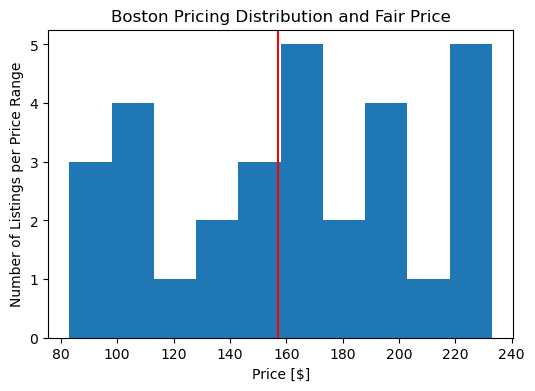

In [14]:
'''
The minimum and maximum similarities must be determined in order to report a logical amount of
of listings.  For example:  If the top n-number of suggestions are all the same similarity, then
technically, all others should be reported with the same similarity score - or at least the prices
for the identical similarity scores.

If the similarity scores are not the same, then simply report the top n-number of listings's prices.
'''
max_sim = sim_df['similarity'][0:num_recs].max()
min_sim = sim_df['similarity'][0:num_recs].min()

if max_sim == min_sim:
    # find all indexzes with that similarity
    suggested_indexes = sim_df[sim_df['similarity'] == min_sim]['listing_index']
    
    # Find all the prices for those indexes suggested above
    suggested_prices = sim_df[sim_df['similarity'] == min_sim]['price']
    
else:
    # Just give the top num_recs similarity differences
    suggested_indexes = sim_df[0:num_recs]['listing_index']
    
    # Find all the prices for those indexes suggested above
    suggested_prices = sim_df[0:num_recs]['price']

plt.figure(figsize = (6, 4))
plt.title('Boston Pricing Distribution and Fair Price')
plt.hist(suggested_prices, bins = 10)
plt.xlabel('Price [$]')
plt.ylabel('Number of Listings per Price Range')
plt.axvline(rec_predict, color = 'red')


# =========== REFORMAT THIS CODE TO WORK FOR YOU =======================
# Here's the source:  https://matplotlib.org/3.3.4/gallery/recipes/placing_text_boxes.html

# textstr = '\n'.join((
#     r'$\mu=%.2f$' % (mu, ),
#     r'$\mathrm{median}=%.2f$' % (median, ),
#     r'$\sigma=%.2f$' % (sigma, )))

# textstr = f'{rec_predict}'

# #ax.hist(x, 50)
# # these are matplotlib.patch.Patch properties
# props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# # place a text box in upper left in axes coords
# plt.text(0.05, 0.95, textstr, transform=plt.transAxes, fontsize=14,
#         verticalalignment='top', bbox=props)

# ======================= REFORMAT ABOVE CODE ==========================

# NOTE !!!! - may need to fix this code later to swap out lstn
lstn.iloc[suggested_indexes]